# Исследование по выбору хранилища для данных

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 3.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 4.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 4.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 4.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━

### Список сравниваемых хранилищ для данных


* PostgreSQL
* MongoDB

In [1]:
import abc
import time
import functools
import json
import os
import pprint
from datetime import datetime
from random import choice, choices, randint
from typing import Callable, Optional, Any
from uuid import uuid4, uuid1

from dotenv import find_dotenv
from faker import Faker
from pydantic import BaseSettings, Field
from pymongo import MongoClient
from tqdm import tqdm

In [2]:
class Settings(BaseSettings):
    MONGO_HOST: str = Field(default="127.0.0.1")
    MONGO_PORT: int = Field(default=27017)
    MONGO_DB: str = Field(default="ugc_db")
    MONGO_COLL_LIKE: str
    MONGO_COLL_REVIEW: str
    MONGO_COLL_BOOKMARK: str
    
    POSTGRES_DB_HOST: str = Field(default="127.0.0.1")
    POSTGRES_DB_PORT: int = Field(default=5432)
    POSTGRES_DB: str
    POSTGRES_USER: str
    POSTGRES_PASSWORD: str

    BATCH_SIZE: int = Field(default=500, description="Размер батча для вставки")
    BATCH_NUMBER: int = Field(default=100, description="Количетсво батчей")
    USERS_NUMBER: int = Field(default=1000, description="Количество уникальных пользователей")
    MOVIES_NUMBER: int = Field(default=1000, description="Количество уникальных фильмов")
    ITERATIONS: int = Field(default=10,description="Количество итераций для замера времени выполнения запроса к хранилищу")
    BATCH_SIZE_LOAD: int = Field(default=100, description="Количество записей при вставке под нагрузкой")
    DELAY_LOAD: float = Field(default=0.001, description="Время задержки между запросами при тестировании под нагрузкой")
    
    MIN_RT = 0
    MAX_RT = 10
    
    class Config:
        env_file = find_dotenv(filename=".env", usecwd=True)
        env_file_encoding = 'utf-8'

settings = Settings()

## Генерация данных

In [4]:
class FabricData:
    users_id = [str(uuid4()) for _ in range(settings.USERS_NUMBER)]
    movies_id = [str(uuid4()) for _ in range(settings.MOVIES_NUMBER)]
    fake = Faker()
    
    def fake_batch(self, event_faker: Callable, users: list = None, batch_size: int = 500) -> list[dict]:
        if not users:
            users = self.users_id
        return [event_faker(user_id=choice(users)) for _ in range(batch_size)]
    
    def fake_movie_likes(self, user_id: Optional[str] = None, film_id: Optional[str] = None) -> dict:
        return {
            "user_id": user_id if user_id else str(uuid4()),
            "movie_id": film_id if film_id else str(uuid4()),
            "rt_value": choice([settings.MIN_RT, settings.MAX_RT]),
            "created": self.fake.date_time_between(start_date="-30d", end_date="-15d"),
            "modified": self.fake.date_time_between(start_date="-15d", end_date="now"),
        }

    def fake_movie_reviews(self, user_id: Optional[str] = None, film_id: Optional[str] = None) -> dict:
        return {
            "user_id": user_id if user_id else str(uuid4()),
            "movie_id": film_id if film_id else str(uuid4()),
            "review": self.fake.text(),
            "rating": randint(0, 500),
            "created": self.fake.date_time_between(start_date="-30d", end_date="-15d"),
            "modified": self.fake.date_time_between(start_date="-30d", end_date="now"),
        }

    def fake_movie_bookmarks(self, user_id: Optional[str] = None, film_id: Optional[str] = None) -> dict:
        return {
            "user_id": user_id if user_id else str(uuid4()),
            "movie_id": film_id if film_id else str(uuid4()),
            "created": self.fake.date_time_between(start_date="-30d", end_date="-15d"),
        }

In [3]:
class BaseStorage:
    @abc.abstractmethod
    def save_state(self, state: dict) -> None:
        pass

    @abc.abstractmethod
    def retrieve_state(self) -> dict:
        pass


class JsonFileStorage(BaseStorage):
    def __init__(self, file_path: str | None = None):
        self.file_path = file_path

    def save_state(self, state: dict) -> None:
        prev_state = self.retrieve_state()
        prev_state.update(state)
        with open(self.file_path, 'w', encoding='utf-8') as json_file:
            json.dump(prev_state, json_file, indent=4, sort_keys=True, default=str)

    def retrieve_state(self) -> dict:
        try:
            with open(self.file_path, 'r', encoding='utf-8') as json_file:
                state = json.load(json_file)
        except FileNotFoundError:
            state = {}
        except json.decoder.JSONDecodeError:
            state = {}
        return state


PATH_TO_STORAGE = os.path.join(os.getcwd(), 'benchmarks.json')
storage = JsonFileStorage(file_path=PATH_TO_STORAGE)

## MongoDB

In [6]:
class TestMongo:
    def __init__(self, settings: Settings, fabric: FabricData, storage: BaseStorage):
        self.settings = settings
        self.storage = storage
        self.fabric = fabric
        self.client = self.get_client()
    
    def get_client(self):
        return MongoClient(self.settings.MONGO_HOST, self.settings.MONGO_PORT, connect=True)
    
    def get_db(self, db: str = "ugc_db"):
        return self.client[db]
    
    def get_list_collection_names(self, db: str = "ugc_db"):
        return self.get_db(db).list_collection_names()
    
    def get_databases_name(self):
        return self.client.get_databases_name()
    
    def get_count_from_coll(self, coll: str = "movie_likes", db: str = "ugc_db"):
        return self.get_db(db)[coll].count_documents({})
    
    def clear_collections(self, coll: str, db: str = "ugc_db"):
        self.get_db(db)[coll].delete_many({})
    
    def test_insert(self, coll_name: str, db: str = "ugc_db"):
        """Тестирование записи данных."""
        mongo_db = self.get_db(db)
        tmp = []
        collection = mongo_db[coll_name]
        collection.delete_many({})
        for i in range(self.settings.ITERATIONS):
            t_tt = 0
            for j in range(self.settings.BATCH_NUMBER):
                func_name = [i for i in self.fabric.__dir__() if coll_name in i][0]
                batch = self.fabric.fake_batch(getattr(self.fabric, func_name), batch_size=self.settings.BATCH_SIZE)
                t0 = time.time()
                collection.insert_many(batch)
                t1 = time.time() - t0
                t_tt += t1
            tmp.append(t_tt)
        mean = sum(tmp) / len(tmp)
        result = self.storage.retrieve_state()
        if "mongo" not in result:
            result["mongo"] = {}
        result["mongo"].update({func_name: mean})
        self.storage.save_state(state={"mongo": result["mongo"]})
        return result
    
    def test_read(self, coll_name: str, users: Optional[str] = None, db: str = "ugc_db", load: bool = False):
        """Тестирование чтения данных."""
        mongo_db = self.get_db(db)
        tmp = []
        collection = mongo_db[coll_name]
        func_name = [i for i in self.fabric.__dir__() if coll_name in i][0]
        if not users:
            users = choices(self.fabric.users_id, k=10)
        if not load:
            collection.delete_many({})
            for i in range(self.settings.BATCH_NUMBER):
                batch = self.fabric.fake_batch(getattr(self.fabric, func_name), users=users, batch_size=self.settings.BATCH_SIZE)
                collection.insert_many(batch)
        for i in range(self.settings.ITERATIONS):
            t_tt = 0
            for user in users:
                t0 = time.time()
                _ = list(collection.find({"user_id": user}))
                t1 = time.time() - t0
                t_tt += t1
            tmp.append(t_tt)
        mean = sum(tmp) / len(tmp)
        result = self.storage.retrieve_state()
        if "mongo" not in result:
            result["mongo"] = {}
        key = f"{func_name}_read" if not load else f"{func_name}_read_load"
        result["mongo"].update({key: mean})
        self.storage.save_state(state={"mongo": result["mongo"]})
        return result

### Тестирование записи

In [7]:
fabric = FabricData()
test_storage = TestMongo(settings=settings, fabric=fabric, storage=storage)
collections = test_storage.get_list_collection_names()
lst_coll = [settings.MONGO_COLL_LIKE, settings.MONGO_COLL_REVIEW, settings.MONGO_COLL_BOOKMARK]
for coll in lst_coll:
    print(f"Load to collection - {coll}")
    result = test_storage.test_insert(coll)
    count = test_storage.get_count_from_coll(coll=coll)
    print(f"Load docs - {count}")
    test_storage.clear_collections(coll=coll)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(result)

Load to collection - movie_likes
Load docs - 1000000
Load to collection - movie_reviews
Load docs - 1000000
Load to collection - movie_bookmarks
Load docs - 1000000
{   'mongo': {   'fake_movie_bookmarks': 1.1342878341674805,
                 'fake_movie_bookmarks_read': 0.5036333322525024,
                 'fake_movie_bookmarks_read_load': 0.7745741367340088,
                 'fake_movie_likes': 1.3336148977279663,
                 'fake_movie_likes_read': 0.47340807914733884,
                 'fake_movie_likes_read_load': 0.7780178546905517,
                 'fake_movie_reviews': 1.4179596900939941,
                 'fake_movie_reviews_read': 0.5145602226257324,
                 'fake_movie_reviews_read_load': 0.870538330078125},
    'postgres': {   'fake_movie_bookmarks': 4.64122440814972,
                    'fake_movie_bookmarks_read': 0.008490490913391113,
                    'fake_movie_bookmarks_read_load': 0.7745741367340088,
                    'fake_movie_likes': 4.723430275

### Тестирование чтения

In [8]:
fabric = FabricData()
USERS = choices(fabric.users_id, k=10)
test_storage = TestMongo(settings=settings, fabric=fabric, storage=storage)
for coll in lst_coll:
    print(f"Load to collection - {coll}")
    result = test_storage.test_read(coll_name=coll, users=USERS)
    count = test_storage.get_count_from_coll(coll=coll)
    print(f"Load docs - {count}")
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(result)

Load to collection - movie_likes
Load docs - 100000
Load to collection - movie_reviews
Load docs - 100000
Load to collection - movie_bookmarks
Load docs - 100000
{   'mongo': {   'fake_movie_bookmarks': 1.1342878341674805,
                 'fake_movie_bookmarks_read': 0.6438698053359986,
                 'fake_movie_bookmarks_read_load': 0.7745741367340088,
                 'fake_movie_likes': 1.3336148977279663,
                 'fake_movie_likes_read': 0.6684442520141601,
                 'fake_movie_likes_read_load': 0.7780178546905517,
                 'fake_movie_reviews': 1.4179596900939941,
                 'fake_movie_reviews_read': 0.7365741491317749,
                 'fake_movie_reviews_read_load': 0.870538330078125},
    'postgres': {   'fake_movie_bookmarks': 4.64122440814972,
                    'fake_movie_bookmarks_read': 0.008490490913391113,
                    'fake_movie_bookmarks_read_load': 0.7745741367340088,
                    'fake_movie_likes': 4.7234302759170

### Тестирование чтения при параллельной записи

Запустим параллельную загрузку данных в коллекции с частоной 1/DELAY_LOAD

In [13]:
import asyncio

BATCH_SIZE_LOAD = settings.BATCH_SIZE_LOAD
DELAY_LOAD = settings.DELAY_LOAD

async def insert_data(fabric: FabricData, settings: BaseSettings, storage: BaseStorage, coll_name: str = "movie_likes"):
    mongo = TestMongo(settings=settings, fabric=fabric, storage=storage)
    mongo_db = mongo.get_db()
    collection = mongo_db[coll_name]
    func_name = [i for i in fabric.__dir__() if coll_name in i][0]
    while True:
        batch = fabric.fake_batch(getattr(fabric, func_name), users=USERS, batch_size=BATCH_SIZE_LOAD)
        collection.insert_many(batch)
        await asyncio.sleep(DELAY_LOAD)

loop = asyncio.get_event_loop()
for coll in lst_coll:
    loop.create_task(insert_data(fabric=fabric, settings=settings, coll_name=coll))

In [14]:
fabric = FabricData()
test_storage = TestMongo(settings=settings, fabric=fabric, storage=storage)
for coll in lst_coll:
    print(f"Load to collection - {coll}")
    result = test_storage.test_read(coll_name=coll, load=True, users=USERS)
    count = test_storage.get_count_from_coll(coll=coll)
    print(f"Load docs - {count}")
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(result)

Load to collection - movie_likes
Load docs - 115300
Load to collection - movie_reviews
Load docs - 115300
Load to collection - movie_bookmarks
Load docs - 115300
{   'mongo': {   'fake_movie_bookmarks': 1.1348849773406982,
                 'fake_movie_bookmarks_read': 0.7065812349319458,
                 'fake_movie_bookmarks_read_load': 0.7745741367340088,
                 'fake_movie_likes': 1.3482896089553833,
                 'fake_movie_likes_read': 0.6598688364028931,
                 'fake_movie_likes_read_load': 0.7780178546905517,
                 'fake_movie_reviews': 1.4877155303955079,
                 'fake_movie_reviews_read': 0.7570814609527587,
                 'fake_movie_reviews_read_load': 0.870538330078125}}


Остановим ранее запущенные корутины и позже перезапустим ядро

In [16]:
loop.stop()

## PostgreSQL

In [9]:
import re
from contextlib import contextmanager, closing
from dataclasses import astuple
from typing import Generator

import psycopg2
from psycopg2.extras import DictCursor, execute_batch

In [10]:
class TestPostgres:
    def __init__(self, fabric: FabricData, settings: Settings, storage: BaseStorage):
        self.settings = settings
        self.fabric = fabric
        self.storage = storage
    
    def _connect(self) -> psycopg2.extras.DictCursor:
        PG = {
            "database": self.settings.POSTGRES_DB,
            "user": self.settings.POSTGRES_USER,
            "password": self.settings.POSTGRES_PASSWORD,
            "host": self.settings.POSTGRES_DB_HOST,
            "port": self.settings.POSTGRES_DB_PORT,
        }
        connection = psycopg2.connect(**PG, cursor_factory=DictCursor)
        return connection
    
    def get_count_from_coll(self, coll_name: str):
        connection = self._connect()
        query = "SELECT count(*) from {};".format(coll_name)
        data = []
        with connection.cursor() as cur:
            cur.execute(query, data)
            result = cur.fetchone()
        result = [r for r in result]
        connection.close()
        return result
    
    def get_n_rows(self, coll_name : str, n : int = 10):
        connection = self._connect()
        query = "SELECT * from {} LIMIT {};".format(coll_name, n)
        data = []
        with connection.cursor() as cur:
            cur.execute(query, data)
            result = cur.fetchall()
        connection.close()
        return result
    
    def clear_collections(self, coll_name: str):
        connection = self._connect()
        query = "DELETE FROM {};".format(coll_name)
        data = []
        with connection.cursor() as cur:
            cur.execute(query)
        connection.commit()
        connection.close()
    
    def test_insert(self, coll_name: str):
        """Тестирование записи данных."""
        connection = self._connect()
        tmp = []
        with connection.cursor() as cur:
            for i in range(self.settings.ITERATIONS):
                t_tt = 0
                for j in range(self.settings.BATCH_NUMBER):
                    func_name = [i for i in self.fabric.__dir__() if coll_name in i][0]
                    batch = self.fabric.fake_batch(getattr(self.fabric, func_name), batch_size=self.settings.BATCH_SIZE)
                    fields = "id, " + ", ".join([field for field in batch[0].keys()])
                    values = [[str(uuid1()), *row.values()] for row in batch]
                    places = ("%s, "*len(values[0]))[:-2]
                    query = """
                    INSERT INTO {table} ({fields})
                    VALUES ({places})
                    ON CONFLICT (id) DO NOTHING
                    """.format(
                        table=coll_name, fields=fields, places=places
                    )
                    t0 = time.time()
                    execute_batch(cur, query, values)
                    connection.commit()
                    t1 = time.time() - t0
                    t_tt += t1
                tmp.append(t_tt)
        connection.close()
        mean = sum(tmp) / len(tmp)
        result = self.storage.retrieve_state()
        if "postgres" not in result:
            result["postgres"] = {}
        result["postgres"].update({func_name: mean})
        self.storage.save_state(state={"postgres": result["postgres"]})
        return result
    
    def test_read(self, coll_name: str, users: Optional[str] = None, db: str = "ugc_db", load: bool = False):
        """Тестирование чтения данных."""
        connection = self._connect()
        tmp = []
        func_name = [i for i in self.fabric.__dir__() if coll_name in i][0]
        if not users:
            users = choices(self.fabric.users_id, k=10)
        if not load:
            self.clear_collections(coll_name=coll_name)
            for i in range(self.settings.BATCH_NUMBER):
                with connection.cursor() as cur:
                    batch = self.fabric.fake_batch(getattr(self.fabric, func_name), batch_size=self.settings.BATCH_SIZE)
                    fields = "id, " + ", ".join([field for field in batch[0].keys()])
                    values = [[str(uuid1()), *row.values()] for row in batch]
                    places = ("%s, "*len(values[0]))[:-2]
                    query = """
                    INSERT INTO {table} ({fields})
                    VALUES ({places})
                    ON CONFLICT (id) DO NOTHING
                    """.format(
                        table=coll_name, fields=fields, places=places
                    )
                    execute_batch(cur, query, values)
                    connection.commit()
        query = "SELECT * from {table} WHERE user_id = '{user_id}';"
        with connection.cursor() as cur:
            for i in range(self.settings.ITERATIONS):
                t_tt = 0
                for user in users:
                    t0 = time.time()
                    cur.execute(query.format(table=coll_name, user_id=user))
                    result = cur.fetchall()
                    t1 = time.time() - t0
                    t_tt += t1
                tmp.append(t_tt)
        connection.close()
        mean = sum(tmp) / len(tmp)
        result = storage.retrieve_state()
        if "postgres" not in result:
            result["postgres"] = {}
        key = f"{func_name}_read" if not load else f"{func_name}_read_load"
        result["postgres"].update({key: mean})
        storage.save_state(state={"postgres": result["postgres"]})
        return result

## Тестирование записи

In [11]:
fabric = FabricData()
test_storage = TestPostgres(settings=settings, fabric=fabric, storage=storage)
lst_coll = [settings.MONGO_COLL_LIKE, settings.MONGO_COLL_REVIEW, settings.MONGO_COLL_BOOKMARK]
for coll in lst_coll:
    print(f"Load to collection - {coll}")
    result = test_storage.test_insert(coll)
    count = test_storage.get_count_from_coll(coll_name=coll)
    print(f"Load docs - {count}")
    test_storage.clear_collections(coll_name=coll)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(result)

Load to collection - movie_likes
Load docs - [1000000]
Load to collection - movie_reviews
Load docs - [1000000]
Load to collection - movie_bookmarks
Load docs - [1000000]
{   'mongo': {   'fake_movie_bookmarks': 1.1342878341674805,
                 'fake_movie_bookmarks_read': 0.6438698053359986,
                 'fake_movie_bookmarks_read_load': 0.7745741367340088,
                 'fake_movie_likes': 1.3336148977279663,
                 'fake_movie_likes_read': 0.6684442520141601,
                 'fake_movie_likes_read_load': 0.7780178546905517,
                 'fake_movie_reviews': 1.4179596900939941,
                 'fake_movie_reviews_read': 0.7365741491317749,
                 'fake_movie_reviews_read_load': 0.870538330078125},
    'postgres': {   'fake_movie_bookmarks': 4.28646399974823,
                    'fake_movie_bookmarks_read': 0.008490490913391113,
                    'fake_movie_bookmarks_read_load': 0.7745741367340088,
                    'fake_movie_likes': 4.8035

## Тестирование чтения

In [26]:
fabric = FabricData()
USERS = choices(fabric.users_id, k=10)
test_storage = TestPostgres(settings=settings, fabric=fabric, storage=storage)
lst_coll = [settings.MONGO_COLL_LIKE, settings.MONGO_COLL_REVIEW, settings.MONGO_COLL_BOOKMARK]
for coll in lst_coll:
    print(f"Load to collection - {coll}")
    result = test_storage.test_read(coll_name=coll, users=USERS)
    count = test_storage.get_count_from_coll(coll_name=coll)
    print(f"Load docs - {count}")
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(result)

Load to collection - movie_likes
Load docs - [100000]
Load to collection - movie_reviews
Load docs - [100000]
Load to collection - movie_bookmarks
Load docs - [100000]
{   'mongo': {   'fake_movie_bookmarks': 1.1348849773406982,
                 'fake_movie_bookmarks_read': 0.7065812349319458,
                 'fake_movie_bookmarks_read_load': 0.7745741367340088,
                 'fake_movie_likes': 1.3482896089553833,
                 'fake_movie_likes_read': 0.6598688364028931,
                 'fake_movie_likes_read_load': 0.7780178546905517,
                 'fake_movie_reviews': 1.4877155303955079,
                 'fake_movie_reviews_read': 0.7570814609527587,
                 'fake_movie_reviews_read_load': 0.870538330078125},
    'postgres': {   'fake_movie_bookmarks': 4.64122440814972,
                    'fake_movie_bookmarks_read': 0.008490490913391113,
                    'fake_movie_bookmarks_read_load': 0.7745741367340088,
                    'fake_movie_likes': 4.7234302

In [12]:
import asyncio

BATCH_SIZE_LOAD = settings.BATCH_SIZE_LOAD
DELAY_LOAD = settings.DELAY_LOAD

async def insert_data(fabric: FabricData, settings: BaseSettings, coll_name: str = "movie_likes"):
    PG = {
        "database": settings.POSTGRES_DB,
        "user": settings.POSTGRES_USER,
        "password": settings.POSTGRES_PASSWORD,
        "host": settings.POSTGRES_DB_HOST,
        "port": settings.POSTGRES_DB_PORT,
    }
    connection = psycopg2.connect(**PG, cursor_factory=DictCursor)
    func_name = [i for i in fabric.__dir__() if coll_name in i][0]
    with connection.cursor() as cur:
        while True:
            batch = fabric.fake_batch(getattr(fabric, func_name), batch_size=settings.BATCH_SIZE)
            fields = "id, " + ", ".join([field for field in batch[0].keys()])
            values = [[str(uuid1()), *row.values()] for row in batch]
            places = ("%s, "*len(values[0]))[:-2]
            query = """
            INSERT INTO {table} ({fields})
            VALUES ({places})
            ON CONFLICT (id) DO NOTHING
            """.format(
                table=coll_name, fields=fields, places=places
            )
            execute_batch(cur, query, values)
            connection.commit()
            await asyncio.sleep(DELAY_LOAD)

loop = asyncio.get_event_loop()
for coll in lst_coll:
    loop.create_task(insert_data(fabric=fabric, settings=settings, coll_name=coll))

### Тестирование чтения при параллельной записи

Запустим параллельную загрузку данных в коллекции с частоной 1/DELAY_LOAD

In [13]:
fabric = FabricData()
USERS = choices(fabric.users_id, k=10)
test_storage = TestPostgres(settings=settings, fabric=fabric, storage=storage)
lst_coll = [settings.MONGO_COLL_LIKE, settings.MONGO_COLL_REVIEW, settings.MONGO_COLL_BOOKMARK]
for coll in lst_coll:
    print(f"Load to collection - {coll}")
    result = test_storage.test_read(coll_name=coll, users=USERS, load=True)
    count = test_storage.get_count_from_coll(coll_name=coll)
    print(f"Load docs - {count}")
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(result)

Load to collection - movie_likes
Load docs - [101000]
Load to collection - movie_reviews
Load docs - [101000]
Load to collection - movie_bookmarks
Load docs - [101000]
{   'mongo': {   'fake_movie_bookmarks': 1.1342878341674805,
                 'fake_movie_bookmarks_read': 0.6438698053359986,
                 'fake_movie_bookmarks_read_load': 0.7745741367340088,
                 'fake_movie_likes': 1.3336148977279663,
                 'fake_movie_likes_read': 0.6684442520141601,
                 'fake_movie_likes_read_load': 0.7780178546905517,
                 'fake_movie_reviews': 1.4179596900939941,
                 'fake_movie_reviews_read': 0.7365741491317749,
                 'fake_movie_reviews_read_load': 0.870538330078125},
    'postgres': {   'fake_movie_bookmarks': 4.28646399974823,
                    'fake_movie_bookmarks_read': 0.008490490913391113,
                    'fake_movie_bookmarks_read_load': 0.07726247310638427,
                    'fake_movie_likes': 4.803534

In [14]:
loop.stop()

In [9]:
benchmarks = storage.retrieve_state()
benchmarks

{'mongo': {'fake_movie_bookmarks': 1.1342878341674805,
  'fake_movie_bookmarks_read': 0.6438698053359986,
  'fake_movie_bookmarks_read_load': 0.7745741367340088,
  'fake_movie_likes': 1.3336148977279663,
  'fake_movie_likes_read': 0.6684442520141601,
  'fake_movie_likes_read_load': 0.7780178546905517,
  'fake_movie_reviews': 1.4179596900939941,
  'fake_movie_reviews_read': 0.7365741491317749,
  'fake_movie_reviews_read_load': 0.870538330078125},
 'postgres': {'fake_movie_bookmarks': 4.28646399974823,
  'fake_movie_bookmarks_read': 0.008490490913391113,
  'fake_movie_bookmarks_read_load': 0.07726247310638427,
  'fake_movie_likes': 4.8035348653793335,
  'fake_movie_likes_read': 0.00990300178527832,
  'fake_movie_likes_read_load': 0.08154492378234864,
  'fake_movie_reviews': 5.744302678108215,
  'fake_movie_reviews_read': 0.00955514907836914,
  'fake_movie_reviews_read_load': 0.1014859676361084}}

# Результаты

Таблица затрачиваемого времени для вставки 100000 записей и выборки данных (по user_id) вхранилища MongoDB и Postgres приведена ниже.

In [11]:
import pandas as pd

In [10]:
table = pd.DataFrame.from_dict(benchmarks)
table.columns = ["Mongo, ms", "Postgres, ms"]
table = table.iloc[:,:]*1000
table["Mongo / Postgres"] = table.iloc[:,-1] / table.iloc[:,-2]
table

,"Mongo, ms","Postgres, ms",Mongo / Postgres
fake_movie_bookmarks,1134.287834,4286.464000,3.778991
fake_movie_bookmarks_read,643.869805,8.490491,0.013187
fake_movie_bookmarks_read_load,774.574137,77.262473,0.099748
fake_movie_likes,1333.614898,4803.534865,3.601891
fake_movie_likes_read,668.444252,9.903002,0.014815
fake_movie_likes_read_load,778.017855,81.544924,0.104811
fake_movie_reviews,1417.959690,5744.302678,4.051104
fake_movie_reviews_read,736.574149,9.555149,0.012972
fake_movie_reviews_read_load,870.538330,101.485968,0.116578


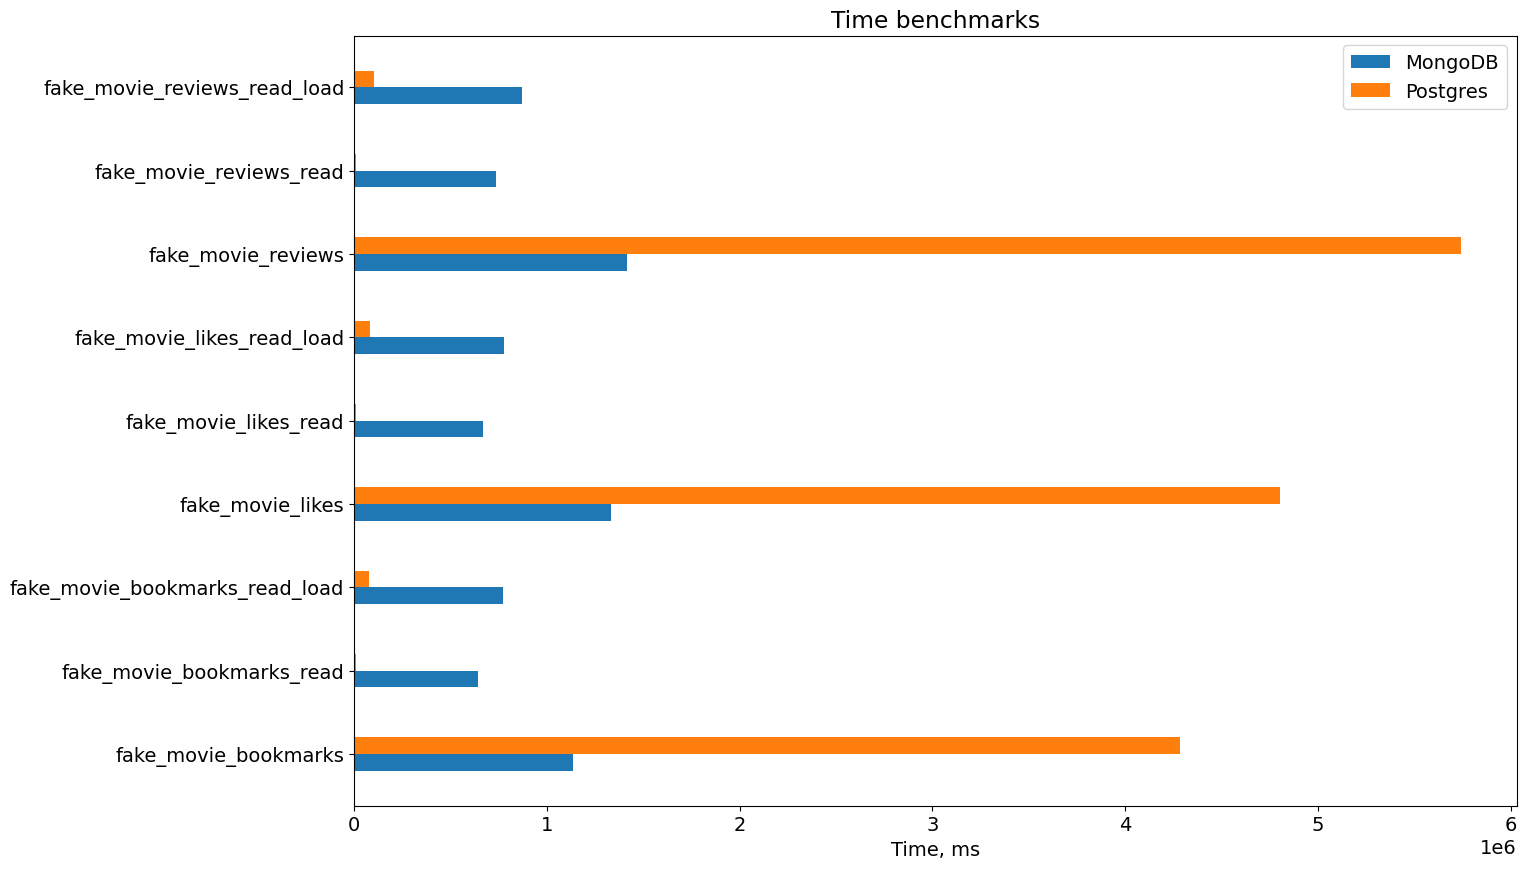

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 14})

labels = table.index.values.tolist()
mongo = [value*1000 if value else 0 for value in table.iloc[:, 0].tolist()]
postgres = [value*1000 if value else 0 for value in table.iloc[:, 1].tolist()]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.barh(x - width/2, mongo, width, label='MongoDB')
rects2 = ax.barh(x + width/2, postgres, width, label='Postgres')

ax.set_xlabel('Time, ms')
ax.set_title('Time benchmarks')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.legend()

plt.show()

Из полученных данных хранилище PostgreSQL уступает MongoDB в скорости записи, однако существенно превосходит последнюю в скорости чтения. MongoDB проще масштабируется и документоориентирована, в связи с чем была выбрано, как основное хранилище данных лайков, рецензий и закладок.